In [74]:
import functions as mf
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as la
from scipy.special import lambertw

import importlib
importlib.reload(mf)

<module 'functions' from 'c:\\Users\\brent\\Documents\\comp_multphase_flow\\functions.py'>

In [188]:
rho_plasma = 1003 #  kg/m3
mu_plasma = 1e-3 # kg/ms

rho_RBC = 1096 # kg/m3
diameter_RBC = 8e-6 # m
volume_fraction_RBC = 0.2

y_end = 5e-3 # m
Ny = 1000
angle = 0 #np.pi / 2

boundary_condition = [1, 1] 
blood_flow_rate = 20e-3 # m/s  # moet gecheckt worden
Q_des = 185*1e-6 #m3/s total bloodflow
pressure_difference = 1e-3
pressure_boundary = np.array([1, 1])*1e-3
system = mf.Multiflow(Ny, y_end, rho_plasma, pressure_difference,
                      pressure_boundary, boundary_condition, mu_plasma, angle)
mu = system.calc_mu(mu_plasma)


def reloadsystem():
    importlib.reload(mf)
    system = mf.Multiflow(Ny, y_end, rho_plasma, pressure_difference,
                      pressure_boundary, boundary_condition, mu_plasma, angle)
    return system


# Plan van aanpak
1D model
1. define system parameters
2. solve laminar
3. solve prantdl in while loop
4. solve wall function in while loop
5. solve alpha2
6. solve velocity u

53
0.00018491037999106798 0.000185


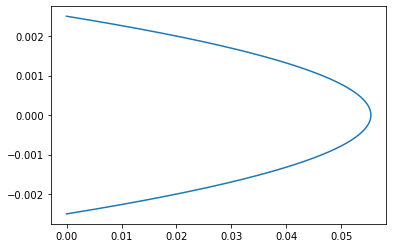

In [189]:
# Prescribed flow rate
# Q_des = np.pi * (system.y_end/2)**2 * blood_flow_rate
eps = 1e-3
error = 1
system.set_pressure_difference(pressure_difference)

velocity = system.simulate(mu)
Q = np.trapz(velocity, x=system.y)
factor = 0.95
#P = [system.pressure_difference, 2*system.pressure_difference]
switch = [0,0]

while error > eps:
    if switch[-2] != switch[-1]:
        factor*=0.9
    if Q<Q_des:
        # system.pressure_difference = P[-1] + np.abs(P[-1]-P[-2])/2 * factor
        system.pressure_difference += system.pressure_difference * factor

        velocity = system.simulate(mu)
        Q = np.trapz(velocity, x=system.y)
        error = np.abs((Q-Q_des)/Q_des)
        switch.append(0)
        # P.append(system.pressure_difference)
    else:
        # system.pressure_difference = P[-1] - np.abs(P[-1]-P[-2])/2 * fac
        system.pressure_difference -= system.pressure_difference * factor
        velocity = system.simulate(mu)
        Q = np.trapz(velocity, x=system.y)
        error = np.abs((Q-Q_des)/Q_des)
        # P.append(system.pressure_difference)
        switch.append(1)
    if len(switch) == 300:
        print("Oh nyo, it's bwoken")
        break

velocity_laminar = velocity
mu_laminar = mu

print(len(switch))
plt.plot(velocity, system.y)
print(Q, Q_des)

# Brentl mixing length

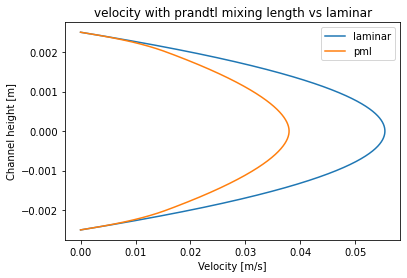

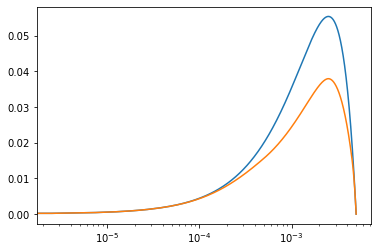

In [190]:
argument_type = None

velocity_new = velocity_laminar

# Then calculate the solution with Prandtl mixing length
eps = 0.01
error = 1
i = 0

# Looping till solution converges
while error > eps:
    velocity = velocity_new

    # Calculate new effective viscosity
    mu_Prandtl = system.calc_mu_Prandtl(velocity, argument_type)

    # Calculate ensuing velocity
    velocity_new = system.simulate(mu_Prandtl)

    error = np.sum(np.abs((velocity_new - velocity) / velocity))
    i+=1
    print("iteration", i, "with error", error, end='\r')

    if i > 2000:
        print("Oh nyo, it's bwoken")
        break

velocity_turbulent = velocity_new
mu_turbulent = mu_Prandtl

plt.plot(velocity_laminar, system.y, label="laminar")
plt.plot(velocity_turbulent, system.y, label="pml")
plt.title("velocity with prandtl mixing length vs laminar")
plt.xlabel('Velocity [m/s]')
plt.ylabel('Channel height [m]')
plt.legend()
plt.show()

# Check for log region
plt.plot(system.y + system.y_end / 2, velocity_laminar)
plt.plot(system.y + system.y_end / 2, velocity_turbulent)
plt.xscale("log")

# Wall functions, two approaches
van dries demping en wall functions bekijken

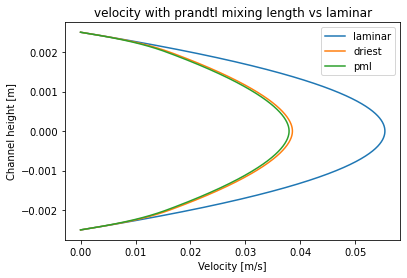

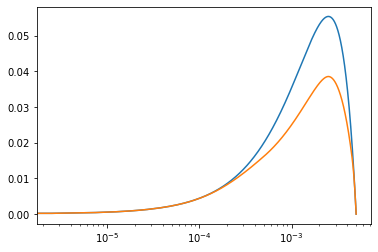

In [191]:
argument_type = "Driest"

velocity_new = velocity_laminar

# Then calculate the solution with Prandtl mixing length
eps = 0.01
error = 1
i = 0

# Looping till solution converges
while error > eps:
    velocity = velocity_new

    # Calculate new effective viscosity
    mu_Prandtl = system.calc_mu_Prandtl(velocity, argument_type)

    # Calculate ensuing velocity
    velocity_new = system.simulate(mu_Prandtl)

    error = np.sum(np.abs((velocity_new - velocity) / velocity))
    i+=1
    print("iteration", i, "with error", error, end='\r')

    if i > 2000:
        print("Oh nyo, it's bwoken")
        break

velocity_Driest = velocity_new
mu_Driest = mu_Prandtl

plt.plot(velocity_laminar, system.y, label="laminar")
plt.plot(velocity_Driest, system.y, label="driest")
plt.plot(velocity_turbulent, system.y, label="pml")

plt.title("velocity with prandtl mixing length vs laminar")
plt.xlabel('Velocity [m/s]')
plt.ylabel('Channel height [m]')
plt.legend()
plt.show()

# Check for log region
plt.plot(system.y + system.y_end / 2, velocity_laminar)
plt.plot(system.y + system.y_end / 2, velocity_Driest)
plt.xscale("log")

In [107]:
"""
# Define constants
kappa = 0.41
E = 9.8
nu = mu_turbulent / system.rho
B = 5.0

# Velocity profile
velocity_new = velocity_turbulent

# First round of calculating variables
u_1 = velocity_new[1]
lamberts_factor = abs(lambertw(u_1 * system.y_wall[1] * kappa * np.exp(kappa * B ) / nu[1]))
u_tau = kappa * u_1 / lamberts_factor
y_plus = system.y_wall * u_tau / nu
print(y_plus[1])

# Define reference tau_w
tau_ref = system.pressure_difference[0] * y_end / 2

error  = 10
epsilon = 1e-7
i=0
while error > epsilon:
  velocity_old = velocity_new
  # Calculate new constant with u_tau != u_1 in log
  u_1 = velocity_new[1]
  lamberts_factor = abs(lambertw(u_1 * system.y_wall[1] * kappa * np.exp(kappa * B ) / nu[1]))
  u_tau = kappa * u_1 / lamberts_factor

  # Calculate tau_w and new constant
  tau_w = system.rho * u_tau**2
  C = tau_w / u_1

  # Velocity shouldn't change on u_1
  velocity_new = system.simulate_wallfunctions(mu_turbulent, C, tau_w)
  
  error = np.abs(np.sum(velocity_new - velocity_old) / np.sum(velocity_old))
  i+=1
  print("iteration", i, "with error", error, end='\r')

print(i)
plt.plot(velocity_new[1:-1])
plt.plot(velocity_turbulent[1:-1])
plt.show()
plt.plot(velocity_new - velocity_turbulent)
"""
"hey"

'hey'

iteration 7 with error 6.104910721787788e-06


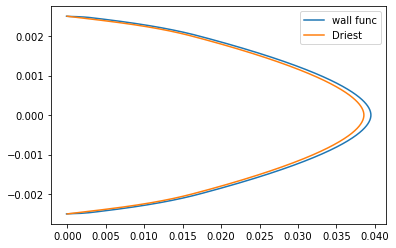

In [203]:
# Wall Function Constants 
velocity_new = velocity_turbulent
E = 9.8
kappa = 0.41
ks = 10 * system.nu_0

i = 0
error = 1
epsilon = 1e-5
while error > epsilon:
    velocity = velocity_new

    # Calculate the new y_plus
    tau_wall = velocity[1] / system.y_wall[1]
    u_tau = np.sqrt(tau_wall / system.rho)
    nu_0 = (mu_turbulent / system.rho)
    y_plus = system.y_wall * u_tau / nu_0

    # Calculate new wall roughness
    ks_plus = u_tau * ks / nu_0[1]
    wall_roughness = 32.6 / ks_plus

    
    # Add new nu for at wall
    nu_plus = np.zeros(system.Ny+2)
    mask = (y_plus < 11.25) * (y_plus > 0)
    nu_plus[mask] = nu_0[mask] * (y_plus[mask] * kappa / np.log(wall_roughness * y_plus[mask]) - 1)
    nu = nu_0 + nu_plus
    mu = nu * system.rho

    # Calculate new velocity
    velocity_new = system.simulate(mu)

    # Error difference in old and new velocity
    error = np.sum(np.abs((velocity_new - velocity) / velocity))
    i+=1
    # print("iteration", i, "with error", error, end='\r')

    if i > 200:
        print("Oh nyo, it's bwoken")
        break

print("iteration", i, "with error", error, end='\n')
plt.plot(velocity_new, system.y, label="wall func")
plt.plot(velocity_Driest, system.y, label="Driest")
plt.legend()
plt.show()

# Euler-euler

c:\Users\brent\Documents\comp_multphase_flow\functions.py:390: RuntimeWarning: divide by zero encountered in true_divide
  - self.rho_particle * alpha_edges[1:] * gamma_edges[1:] * nu_t_edge[1:] * velocity_diff[1:]
c:\Users\brent\Documents\comp_multphase_flow\functions.py:390: RuntimeWarning: invalid value encountered in multiply
  - self.rho_particle * alpha_edges[1:] * gamma_edges[1:] * nu_t_edge[1:] * velocity_diff[1:]


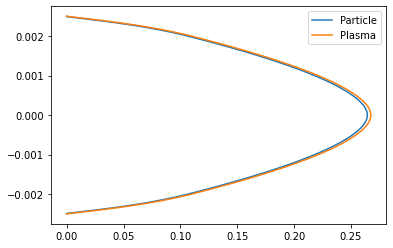

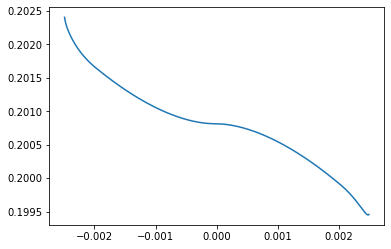

In [155]:
# Add particles to the system
system = reloadsystem()
system.add_particles(rho_RBC, diameter_RBC, volume_fraction_RBC)


# calculate initial alpha of the particles
alpha_particles = system.calc_alpha(velocity_turbulent, mu_turbulent)

# Calculate volumetric plasma concentration
alpha_fluid = 1 - alpha_particles
velocity_new = velocity_turbulent

# While loop to iterate of velocity
i = 0
error = 1
epsilon = 1e-3
while error > epsilon:
    velocity = velocity_new

    # Calculate new velocity
    velocity_new = system.simulate_with_particles(mu_turbulent, alpha_fluid)

    # Error difference in old and new velocity
    error = np.sum(np.abs((velocity_new - velocity) / velocity))
    alpha_particles = system.calc_alpha(velocity_turbulent, mu_turbulent)

    # Calculate volumetric plasma concentration
    alpha_fluid = 1 - alpha_particles
    i+=1

    if i > 200:
        print("Oh nyo, it's bwoken")
        break


velocity_plasma = velocity_new
velocity_particle = system.solve_particle_velocity(alpha_particles, velocity_plasma, mu_turbulent)

plt.plot(velocity_particle, system.y[1:-1],label="Particle")
plt.plot(velocity_plasma, system.y, label="Plasma")
plt.legend()
plt.show()
plt.plot(system.y[alpha_particles != 0], alpha_particles[alpha_particles != 0])
plt.show()

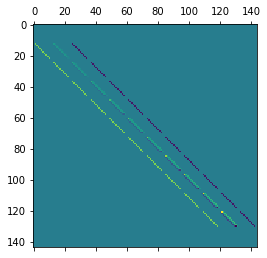

In [99]:
import numpy as np

# coords (z, 4)

z_end = 100
Nz = 10
dz = z_end / Nz
r_end = 10
Nr = 10
dr = r_end / Nr

rho = 1000
mu = 1e-3 * np.ones((Nz + 2, Nr + 2))
pressure = np.ones((Nz + 2, Nr + 2))

# Center
z = np.linspace( -dz / 2, z_end + dz/2, Nz + 2)
r = np.linspace( -dr / 2, r_end + dr/2, Nr + 2)

# Z-offset
z_z = z - dz / 2
r_z = np.copy(r)
ZZ , RZ = np.meshgrid(z_z, r_z)
RZ = np.transpose(RZ)
velocity_z = 2*np.ones((Nz + 2, Nr + 2)) # at z-offset points
velocity_z[0,:] = 0
velocity_z[-1,:] = 0
velocity_z[:,0] = 0
velocity_z[:,-1] = 0

# R-offset
z_r = z
r_r = r - dr / 2
ZR , RR = np.meshgrid(z_r, r_r)
RR = np.transpose(RR)
velocity_r = 3*np.ones((Nz + 2, Nr + 2)) # at r-offset points

let = np.arange(1,10)

# pressure gradient in both z and r direction
pressure_gradient_r = 1 / rho * (pressure[:,:-1] - pressure[:,1:]) * dz
pressure_gradient_z = 1 / rho * (pressure[:-1,:] - pressure[1:,:]) * dr * r


def calc_convective_flux_z(velocity_z, velocity_r):
    matrix = np.zeros((Nz + 2 , Nr+2))
    
    matrix[1:-1,1:-1] = 0.25*(velocity_r[:-2,2:] + velocity_r[1:-1,2:] - velocity_r[:-2,1:-1] - velocity_r[1:-1,1:-1]) * dz + \
                        (velocity_z[1:-1,1:-1] + velocity_z[2:,1:-1]) * RZ[1:-1,2:] * dr + \
                        -(velocity_z[:-2,1:-1] + velocity_z[1:-1,1:-1]) * RZ[1:-1,1:-1] * dr
    diag_i_j = np.reshape(np.copy(matrix), newshape=(-1),  order="F")

    matrix[1:-1,1:-1] = 0.25*(velocity_z[2:,1:-1] + velocity_z[1:-1,1:-1])* RZ[1:-1,2:] * dr
    diag_iplus_j = np.reshape(np.copy(matrix), newshape=(-1),  order="F")

    matrix[1:-1,1:-1] = -0.25*(velocity_z[:-2,1:-1] + velocity_z[1:-1,1:-1])* RZ[1:-1,1:-1] * dr
    diag_imin_j = np.reshape(np.copy(matrix), newshape=(-1),  order="F")

    matrix[1:-1,1:-1] = 0.25*(velocity_r[:-2,2:] + velocity_r[1:-1,2:])* dz
    diag_i_jplus = np.reshape(np.copy(matrix), newshape=(-1),  order="F")

    matrix[1:-1,1:-1] = -0.25*(velocity_r[:-2,1:-1] + velocity_r[1:-1,1:-1])*dz
    diag_i_jmin = np.reshape(np.copy(matrix), newshape=(-1),  order="F")
    
    return diag_i_j, diag_iplus_j, diag_imin_j, diag_i_jplus, diag_i_jmin


def calc_convective_flux_r(velocity_z, velocity_r):
    matrix = np.zeros((Nz + 2 , Nr+2))

    matrix[1:-1,1:-1] = 0.25*(velocity_r[1:-1,2:] - velocity_r[1:-1,:-2]) * dz + \
                        (velocity_z[2:,1:-1] + velocity_z[2:,:-2]) * RR[1:-1,2:] * dr + \
                        -(velocity_z[1:-1,:-2] + velocity_z[1:-1,1:-1]) * RR[1:-1,1:-1] * dr
    diag_i_j = np.reshape(np.copy(matrix), newshape=(-1),  order="F")

    matrix[1:-1,1:-1] = 0.25*(velocity_z[2:,1:-1] + velocity_z[2:,:-2])* RR[1:-1,2:] * dr
    diag_iplus_j =  np.reshape(np.copy(matrix), newshape=(-1),  order="F")

    matrix[1:-1,1:-1] = -0.25*(velocity_z[1:-1,:-2] + velocity_z[1:-1,1:-1])* RR[1:-1,1:-1] * dr
    diag_imin_j =  np.reshape(np.copy(matrix), newshape=(-1),  order="F")

    matrix[1:-1,1:-1] = 0.25*(velocity_r[1:-1,1:-1] + velocity_r[1:-1,2:])* dz
    diag_i_jplus =  np.reshape(np.copy(matrix), newshape=(-1),  order="F")

    matrix[1:-1,1:-1] = -0.25*(velocity_r[1:-1,1:-1] + velocity_r[1:-1,:-2])*dz
    diag_i_jmin =  np.reshape(np.copy(matrix), newshape=(-1),  order="F")
    
    return diag_i_j, diag_iplus_j, diag_imin_j, diag_i_jplus, diag_i_jmin


def calc_diffusive_flux_z(mu):
    matrix = np.zeros((Nz + 2 , Nr+2))

    matrix[1:-1,1:-1] = -mu[1:-1,1:-1] * ((RZ[1:-1,2:] + RZ[1:-1,1:-1]) * dr / dz + 2 * dz / dr)
    diag_i_j = np.reshape(np.copy(matrix), newshape=(-1),  order="F")

    matrix[1:-1,1:-1] = mu[1:-1,1:-1] * RZ[1:-1,2:] * dr / dz
    diag_iplus_j = np.reshape(np.copy(matrix), newshape=(-1),  order="F")

    matrix[1:-1,1:-1] = mu[1:-1,1:-1] * RZ[1:-1,1:-1] * dr / dz
    diag_imin_j = np.reshape(np.copy(matrix), newshape=(-1),  order="F")

    matrix[1:-1,1:-1] = mu[1:-1,1:-1] * dz / dr
    diag_i_jplus = np.reshape(np.copy(matrix), newshape=(-1),  order="F")

    matrix[1:-1,1:-1] = mu[1:-1,1:-1] * dz / dr
    diag_i_jmin = np.reshape(np.copy(matrix), newshape=(-1),  order="F")

    return diag_i_j, diag_iplus_j, diag_imin_j, diag_i_jplus, diag_i_jmin


def calc_diffusive_flux_r(mu):
    matrix = np.zeros((Nz + 2 , Nr+2))
    
    matrix[1:-1,1:-1] = -mu[1:-1,1:-1] * ((RR[1:-1,2:] + RR[1:-1,1:-1]) * dr / dz + 2 * dz / dr)
    diag_i_j = np.reshape(np.copy(matrix), newshape=(-1),  order="F")

    matrix[1:-1,1:-1] = mu[1:-1,1:-1] * dz / dr
    diag_iplus_j = np.reshape(np.copy(matrix), newshape=(-1),  order="F")

    matrix[1:-1,1:-1] = mu[1:-1,1:-1] * dz / dr
    diag_imin_j = np.reshape(np.copy(matrix), newshape=(-1),  order="F")

    matrix[1:-1,1:-1] = mu[1:-1,1:-1] * RR[1:-1,2:] * dr / dz
    diag_i_jplus = np.reshape(np.copy(matrix), newshape=(-1),  order="F")

    matrix[1:-1,1:-1] = mu[1:-1,1:-1] * RR[1:-1,1:-1] * dr / dz
    diag_i_jmin = np.reshape(np.copy(matrix), newshape=(-1),  order="F")

    return diag_i_j, diag_iplus_j, diag_imin_j, diag_i_jplus, diag_i_jmin


def calc_pressure_gradient_z(pressure):
    matrix = np.zeros((Nz + 2 , Nr+2))

    matrix[1:-1,1:-1] = 1 / rho * (pressure[1:-1,1:-1] * dr * RR[1:-1,1:-1] - pressure[:-2,1:-1] * dr * RR [:-2,1:-1])
    pressure_gradient_z = np.reshape(np.copy(matrix), newshape=(-1),  order="F")

    return pressure_gradient_z


def calc_pressure_gradient_r(pressure):
    matrix = np.zeros((Nz + 2 , Nr+2))

    matrix[1:-1,1:-1] = 1 / rho * (pressure[1:-1,1:-1] * dz - pressure[1:-1,:-2] * dz)
    pressure_gradient_r = np.reshape(np.copy(matrix), newshape=(-1),  order="F")

    return pressure_gradient_r


# while not convergent

convective_z = calc_convective_flux_z(velocity_z, velocity_r)
diffusive_z =  calc_diffusive_flux_z(mu)

diag_i_j = convective_z[0] + diffusive_z[0]
diag_iplus_j =  (convective_z[1] + diffusive_z[1])[:-1]
diag_imin_j =   (convective_z[2] + diffusive_z[2])[1:]
diag_i_jplus =  (convective_z[3] + diffusive_z[3])[Nz+2:]
diag_i_jmin =   (convective_z[4] + diffusive_z[4])[:-Nz-2]


pressure_gradient_z = calc_pressure_gradient_z(pressure)
velocity_flattened_z = np.reshape(velocity_z, (-1), order="F")

# Build the matrix
# print(len(diag_i_j),len(diag_imin_j),len(diag_iplus_j),len(diag_i_jmin),len(diag_i_jplus))
# print((diag_i_j))
# print(diag_imin_j)
# print(diag_iplus_j)
# print(diag_i_jmin)
# print(diag_i_jplus)

matrix_A = sp.diags(diagonals=(diag_i_j, diag_imin_j, diag_iplus_j, diag_i_jmin, diag_i_jplus), offsets=(0,-1,1,Nz+2, -Nz-2))
plt.matshow((matrix_A.toarray()))
matrix_A = sp.dia_matrix(matrix_A).tocsr()
new_velocity = la.spsolve(matrix_A, pressure_gradient_z)

In [31]:
np.zeros((3,3*5))

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])